## env

In [1]:
!nvidia-smi -L
!nvcc -V
!nvidia-smi

GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-1242830d-0dff-bf8c-ac33-61a08f8c447a)
GPU 1: NVIDIA A100-SXM4-40GB (UUID: GPU-7d81048e-a999-9a44-bacb-6cfa0327cc98)
GPU 2: NVIDIA A100-SXM4-40GB (UUID: GPU-77e505f3-e454-9468-bf4c-a21cf5e7dac6)
GPU 3: NVIDIA A100-SXM4-40GB (UUID: GPU-b3a0be24-9fd6-96c5-f6df-a78b70e2096a)
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Fri Jul 22 17:36:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|========

In [2]:
import os
# TF_ENABLE_ONEDNN_OPTS=0
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import sys
sys.path.append('Code/code/')
from load_data import load_MEG_dataset
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from torch.cuda import amp
import torch.nn.functional as F
import math
# %env CUBLAS_WORKSPACE_CONFIG=:16:8
from scipy.integrate import simps
from mne.time_frequency import psd_array_welch
from band_power import (
    bandpower_multi_bands,
    standard_scaling_sklearn,
)

/users/k21116947/miniconda3/envs/Mnet/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-07-22 17:36:27.163745: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-22 17:36:27.169879: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-22 17:36:27.169902: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
device = torch.device('cuda' if  torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Mnet

## Load

In [45]:
Split = 0.90
X_train, y_train = load_MEG_dataset([str(i).zfill(3) for i in range(1,2)], mode = 'concatenate', output_format='numpy',shuffle = True, training=True, train_test_split=Split, batch_size=500)
X_test, y_test = load_MEG_dataset([str(i).zfill(3) for i in range(1,2)], mode = 'concatenate', output_format='numpy',shuffle = True, training=False, train_test_split=Split, batch_size=500)

X_train = X_train[:, None, ...]
X_test = X_test[:, None, ...]

# X_train=np.repeat(X_train,3,axis=1)
# X_test=np.repeat(X_test,3,axis=1)

y_train = (y_train / 2) - 1
y_test = (y_test / 2) - 1

X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)
y_train_tensors = torch.from_numpy(y_train) 
y_test_tensors = torch.from_numpy(y_test)
# y_train_tensors = F.one_hot(y_train_tensors)
# y_test_tensors = F.one_hot(y_test_tensors)

Loading subject 001
Data loaded
Subject 001 complete
--------------------------------------
Loading subject 001
Data loaded
Subject 001 complete
--------------------------------------


In [46]:
X_train_tensors = F.interpolate(X_train_tensors, size=(272, 800))
X_test_tensors = F.interpolate(X_test_tensors, size=(272, 800))
print(X_train_tensors.shape)

torch.Size([810, 1, 272, 800])


In [47]:
X_train_tensors=X_train_tensors.cuda()
X_test_tensors=X_test_tensors.cuda()
y_train_tensors=y_train_tensors.cuda()
y_test_tensors=y_test_tensors.cuda()
print('done')

done


In [48]:
X_train_tensors.shape

torch.Size([810, 1, 272, 800])

## band power 

In [49]:
X = np.swapaxes(X_train, 2, -1).squeeze()
data = X[X.shape[0]-1, 70, :]
psd_mne, freqs_mne = psd_array_welch(data, 250, 1., 70., n_per_seg=None,
                          n_overlap=0, n_jobs=1)
for low, high in [(1, 4), (4, 8), (8, 10), (10, 13), (13, 30),
                  (30, 70)]:
    print("processing bands (low, high) : ({},{})".format(low, high))
    # Find intersecting values in frequency vector
    idx_delta = np.logical_and(freqs_mne >= low, freqs_mne <= high)
      # Frequency resolution
    freq_res = freqs_mne[1] - freqs_mne[0]  # = 1 / 4 = 0.25

    # Compute the absolute power by approximating the area under the curve
    power = simps(psd_mne[idx_delta], dx=freq_res)
    print('Absolute power: {:.4f} uV^2'.format(power))
    
    total_power = simps(psd_mne, dx=freq_res)
    rel_power = power / total_power
    
    print('Relative power: {:.4f}'.format(rel_power))

Effective window size : 1.024 (s)
processing bands (low, high) : (1,4)
Absolute power: 0.0610 uV^2
Relative power: 0.1251
processing bands (low, high) : (4,8)
Absolute power: 0.0315 uV^2
Relative power: 0.0647
processing bands (low, high) : (8,10)
Absolute power: 0.0220 uV^2
Relative power: 0.0452
processing bands (low, high) : (10,13)
Absolute power: 0.0031 uV^2
Relative power: 0.0064
processing bands (low, high) : (13,30)
Absolute power: 0.0577 uV^2
Relative power: 0.1184
processing bands (low, high) : (30,70)
Absolute power: 0.2356 uV^2
Relative power: 0.4837


In [50]:
X_train_bp = np.squeeze(X_train, axis=1)
# X_train_bp = X_train_bp[: :, :, :]
X_train_bp = standard_scaling_sklearn(X_train_bp)
X_test_bp = np.squeeze(X_test, axis=1)
# X_train_bp = X_train_bp[: :, :, :]
X_test_bp = standard_scaling_sklearn(X_test_bp)
bands = [(1, 4), (4, 8), (8, 10), (10, 13), (13, 30), (30, 70)]
bp_train = bandpower_multi_bands(X_train_bp, fs=100.0, bands=bands, relative=True)
bp_test = bandpower_multi_bands(X_test_bp, fs=100.0, bands=bands, relative=True)
bp_train_tensor = torch.Tensor(bp_train).cuda()
bp_test_tensor = torch.Tensor(bp_test).cuda()

Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective wind

## Parms

In [9]:
CRED    = '\33[31m'
CGREEN  = '\33[32m'
CYELLOW = '\33[33m'
CBLUE   = '\33[34m'

## Functions

In [10]:
class ChannelPool(nn.Module):

    def forward(self, x):
        return torch.cat((torch.max(x, 1)[0].unsqueeze(1),
                          torch.mean(x, 1).unsqueeze(1)), dim=1)

In [11]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int):
                How long to wait after last time validation loss improved.
                Default: 7
            verbose (bool):
                If True, prints a message for each validation loss improvement.
                Default: False
            delta (float):
                Minimum change in the monitored quantity to qualify as an improvement.
                Default: 0
            path (str):
                Path for the checkpoint to be saved to.
                Default: 'checkpoint.pt'
            trace_func (function):
                trace print function.
                Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score <= self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.4f} --> {val_loss:.4f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [12]:
class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.spatialAttention = nn.Sequential(
            ChannelPool(),
            nn.Conv2d(2, 1, 7, 7, padding=3),
            nn.Sigmoid(),
            )

    def forward(self, x):
        attention = self.spatialAttention(x)
        # print(attention.shape)
        # print(x.shape)
        return x * attention


In [13]:
class Flatten_MEG(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

In [14]:
class ChannelAttention(nn.Module):
    """
            Implementation of a channel attention module.
        """
    class Showsize(nn.Module):
        def __init__(self):
            super(ChannelAttention.Showsize, self).__init__()
        def forward(self, x):
            # print(x.shape)
            return x

    def __init__(self, shape, reduction_factor=16):

        super(ChannelAttention, self).__init__()

        _, in_channel, h, w = shape
        self.mlp = nn.Sequential(
            # self.Showsize(),
            Flatten_MEG(),
            # self.Showsize(),
            nn.Linear(in_channel, in_channel // reduction_factor),
            nn.ReLU(),
            nn.Linear(in_channel // reduction_factor, in_channel),
        )
        self.avg = nn.AvgPool2d(kernel_size=(h, w), stride=(h, w))
        self.max = nn.MaxPool2d(kernel_size=(h, w), stride=(h, w))

    def forward(self, x):
        print('x', x.shape)
        avg = self.avg(x)
        max = self.max(x)
        sum = self.mlp(avg) + self.mlp(max)
        # print(sum.shape)
        attention = (
            torch.sigmoid(sum)
            .unsqueeze(2)
            .unsqueeze(3)
        )
        print('att', attention.shape)
        return x * attention


In [15]:
class Concatenate(nn.Module):
    def __init__(self):
        super(Concatenate, self).__init__()

    def forward(self, x, bp):

        # min_ = x.min(1, keepdim=True)[0]
        # if min_[0] < 0:
        #     x = x + min_
        # else:
        #     x = x - min_
        # x = x / x.max()
        x = x.view(x.shape[0], -1)
        bp = bp.view(bp.shape[0], -1)
        x = torch.cat([x, bp], -1)

        return x

In [16]:
def GETcorrectnumber(loader, printcolor):
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(num_classes)]
        n_class_samples = [0 for i in range(num_classes)]
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = rpsmnet(inputs)
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            # n_correct += (predicted == labels).sum().item()
            for k in range(predicted.shape[0]):
                if predicted[k]==labels[k]:
                    n_correct +=1
            # for i in range(num_classes): # accuracy for each class
            #     label = labels[i]
            #     pred = predicted[i]
            #     if (label == pred):
            #         n_class_correct[i] += 1
            #     n_class_samples[i] += 1
        acc = 100.0 * n_correct / n_samples
        print(printcolor+f'[{epoch + 1}] t accuracy： {acc}%'+printcolor)
    return acc

In [17]:
class L1(torch.nn.Module):
    def __init__(self, module, weight_decay):
        super().__init__()
        self.module = module
        self.weight_decay = weight_decay

        # Backward hook is registered on the specified module
        self.hook = self.module.register_full_backward_hook(self._weight_decay_hook)

    # Not dependent on backprop incoming values, placeholder
    def _weight_decay_hook(self, *_):
        for param in self.module.parameters():
            # If there is no gradient or it was zeroed out
            # Zeroed out using optimizer.zero_grad() usually
            # Turn on if needed with grad accumulation/more safer way
            # if param.grad is None or torch.all(param.grad == 0.0):

            # Apply regularization on it
            param.grad = self.regularize(param)

    def regularize(self, parameter):
        # L1 regularization formula
        return self.weight_decay * torch.sign(parameter.data)

    def forward(self, *args, **kwargs):
        # Simply forward and args and kwargs to module
        return self.module(*args, **kwargs)

## RPS_Mnet

In [18]:
class RPS_MNet(nn.Module):
    """
        Model inspired by [Aoe at al., 10.1038/s41598-019-41500-x] integrated with bandpower.
    """
    class Showsize(nn.Module):
        def __init__(self):
            super(RPS_MNet.Showsize, self).__init__()
        def forward(self, x):
            # print(x.shape)
            return x

    def __init__(self, n_times):
        """
        Args:
            n_times (int):
                n_times dimension of the input data.
        """
        super(RPS_MNet, self).__init__()
        # if n_times == 501:  # TODO automatic n_times
        #     self.n_times = 12
        # elif n_times == 601:
        #     self.n_times = 18
        # elif n_times == 701:
        #     self.n_times = 24
        # else:
        #     raise ValueError(
        #         "Network can work only with n_times = 501, 601, 701 "
        #         "(epoch duration of 1., 1.2, 1.4 sec),"
        #         " got instead {}".format(n_times)
        #     )
        self.n_times = n_times
        self.spatial = nn.Sequential(
            nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(272,64), bias=False), #kernel size 204, 64
            nn.ReLU(),
            nn.BatchNorm2d(32),
            self.Showsize(),
            nn.Conv2d(32, 64, stride=(1, 1), kernel_size=(1, 16), bias=False), # kernel size 1,16
            nn.ReLU(),
            self.Showsize(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
            nn.BatchNorm2d(64),
            self.Showsize(),
        )

        self.temporal = nn.Sequential(
            nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(8, 8), bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(32),
            self.Showsize(),
            nn.Conv2d(32, 32, stride=(1, 1), kernel_size=(8, 8), bias=False),
            nn.ReLU(),
            self.Showsize(),
            nn.MaxPool2d(kernel_size=(5, 3), stride=(5, 3)),
            # nn.BatchNorm2d(32),
            self.Showsize(),
            nn.Conv2d(32, 64, stride=(1, 1), kernel_size=(1, 4), bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(64),
            self.Showsize(),
            nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(1, 4), bias=False), #conv6
            nn.ReLU(),
            # nn.BatchNorm2d(64),
            self.Showsize(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
            self.Showsize(),
            nn.Conv2d(64, 128, stride=(1, 1), kernel_size=(1, 2), bias=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),
            # nn.BatchNorm2d(128),
            self.Showsize(),
            nn.Conv2d(128, 128, stride=(1, 1), kernel_size=(1, 2), bias=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),
            # nn.BatchNorm2d(128),
            self.Showsize(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
            self.Showsize(),
            nn.Conv2d(128, 256, stride=(1, 1), kernel_size=(1, 2), bias=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),
            # nn.BatchNorm2d(256),
            self.Showsize(),
            nn.Conv2d(256, 256, stride=(1, 1), kernel_size=(1, 2), bias=False), #conv10
            nn.ReLU(),
            nn.Dropout2d(p=0.3),
            # nn.BatchNorm2d(256),
            self.Showsize(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
            self.Showsize(),

        )

        # self.attention = nn.Sequential(
        #     ChannelAttention([None, 256, 26, self.n_times]), SpatialAttention()
        # )

        self.concatenate = Concatenate()

        self.flatten = Flatten_MEG()

        self.ff1 = nn.Sequential(
            # nn.Linear(256 * 26 * self.n_times + 272 * 6, 1024),
            nn.Linear(30720, 1024),
            nn.BatchNorm1d(num_features=1024),
            nn.ReLU(),
            self.Showsize(),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(num_features=1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            self.Showsize(),
        )
        self.ff2 = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(2656, 14),
        )

    def forward(self, x, pb):
        x = self.spatial(x)
        x = torch.transpose(x, 1, 2)
        x = self.temporal(x)
        # x = self.attention(x)
        x = self.ff1(self.flatten(x))
        x = self.concatenate(x, pb)
        x = self.ff2(x)

        return x.squeeze(1)

In [19]:
# class RPS_MNet(nn.Module):
#     """
#         Model inspired by [Aoe at al., 10.1038/s41598-019-41500-x] integrated with bandpower.
#     """
#     class Showsize(nn.Module):
#         def __init__(self):
#             super(RPS_MNet.Showsize, self).__init__()
#         def forward(self, x):
#             # print(x.shape)
#             return x
        
#     def __init__(self, n_times):
#         """
#         Args:
#             n_times (int):
#                 n_times dimension of the input data.
#         """
#         super(RPS_MNet, self).__init__()
#         if n_times == 501:  # TODO automatic n_times
#             self.n_times = 26
#         elif n_times == 601:
#             self.n_times = 18
#         elif n_times == 701:
#             self.n_times = 24
#         else:
#             raise ValueError(
#                 "Network can work only with n_times = 501, 601, 701 "
#                 "(epoch duration of 1., 1.2, 1.4 sec),"
#                 " got instead {}".format(n_times)
#             )

#         self.spatial = nn.Sequential(
#             nn.Conv2d(1, 32, stride=(1, 1), kernel_size=[272, 64], bias=False),
#             nn.ReLU(),
#             # nn.BatchNorm2d(32),
#             nn.Conv2d(32, 64, kernel_size=[1, 16], bias=False),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=[1, 2], stride=(1, 2)),
#             # self.Showsize(),
#             # nn.BatchNorm2d(64),
#         )


#         self.temporal = nn.Sequential(nn.Conv2d(1, 32, kernel_size=[8, 8], bias=True),
#                                       nn.ReLU(),
#                                       # self.Showsize(),
#                                       # nn.BatchNorm2d(32),
#                                       nn.Conv2d(32, 32, kernel_size=[8, 8], bias=True),
#                                       nn.ReLU(),
#                                       nn.MaxPool2d(kernel_size=[1, 3], stride=(1, 2)),
#                                       # nn.BatchNorm2d(32),
#                                       nn.Conv2d(32, 64, kernel_size=[6, 6], bias=True),
#                                       nn.ReLU(),
#                                       # nn.BatchNorm2d(64),
#                                       nn.Conv2d(64, 64, kernel_size=[6, 6], bias=True),
#                                       nn.ReLU(),
#                                       # nn.BatchNorm2d(64),
#                                       nn.MaxPool2d(kernel_size=[1, 2], stride=(1, 2)),
#                                       nn.Conv2d(64, 128, kernel_size=[5, 5], bias=True),
#                                       nn.ReLU(),
#                                       nn.Dropout2d(p=0.3),
#                                       # nn.BatchNorm2d(128),
#                                       nn.Conv2d(128, 128, kernel_size=[5, 5], bias=True),
#                                       nn.ReLU(),
#                                       nn.Dropout2d(p=0.3),
#                                       # nn.BatchNorm2d(128),
#                                       nn.MaxPool2d(kernel_size=[1, 2], stride=(1, 2)),
#                                       nn.Conv2d(128, 256, kernel_size=[4, 4], bias=True),
#                                       nn.ReLU(),
#                                       nn.Dropout2d(p=0.3),
#                                       # nn.BatchNorm2d(256),
#                                       nn.Conv2d(256, 256, kernel_size=[4, 4], bias=True),
#                                       nn.ReLU(),
#                                       nn.Dropout2d(p=0.3),
#                                       # nn.BatchNorm2d(256),
#                                       # self.Showsize(),
#                                       )

#         self.attention = nn.Sequential(
#             ChannelAttention((None, 256, 26, self.n_times)),
#         )

#         self.attention2 = nn.Sequential(
#             SpatialAttention(),
#         )

#         self.concatenate = Concatenate()

#         # self.flatten = Flatten_MEG()

#         self.ff = nn.Sequential(
#             nn.Linear(256 * 26 * self.n_times + 272 * 6, 1024),
#             nn.BatchNorm1d(num_features=1024),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(1024, 1024),
#             nn.BatchNorm1d(num_features=1024),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(1024, 14),
#         )

#     def forward(self, x, pb):
#         x = self.spatial(x)
#         x = torch.transpose(x, 1, 2)
#         x = self.temporal(x)
#         x = self.attention(x)
#         x = self.attention2(x)
#         x = self.concatenate(x, pb)
#         x = self.ff(x)

#         return x.squeeze(1)

In [41]:
rpsmnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False).cuda()
print(rpsmnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Using cache found in /users/k21116947/.cache/torch/hub/pytorch_vision_v0.10.0


In [115]:
rpsmnet = RPS_MNet(501).cuda()
print(rpsmnet)

RPS_MNet(
  (spatial): Sequential(
    (0): Conv2d(1, 32, kernel_size=(272, 64), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Showsize()
    (4): Conv2d(32, 64, kernel_size=(1, 16), stride=(1, 1), bias=False)
    (5): ReLU()
    (6): Showsize()
    (7): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Showsize()
  )
  (temporal): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): Showsize()
    (3): Conv2d(32, 32, kernel_size=(8, 8), stride=(1, 1), bias=False)
    (4): ReLU()
    (5): Showsize()
    (6): MaxPool2d(kernel_size=(5, 3), stride=(5, 3), padding=0, dilation=1, ceil_mode=False)
    (7): Showsize()
    (8): Conv2d(32, 64, kernel_size=(1, 4), stride=(1, 1), bias=False)
    (9): ReLU()
    (10): Sh

In [36]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(rpsmnet)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv1.weight         |    9408    |
|          bn1.weight          |     64     |
|           bn1.bias           |     64     |
|    layer1.0.conv1.weight     |   36864    |
|     layer1.0.bn1.weight      |     64     |
|      layer1.0.bn1.bias       |     64     |
|    layer1.0.conv2.weight     |   36864    |
|     layer1.0.bn2.weight      |     64     |
|      layer1.0.bn2.bias       |     64     |
|    layer1.1.conv1.weight     |   36864    |
|     layer1.1.bn1.weight      |     64     |
|      layer1.1.bn1.bias       |     64     |
|    layer1.1.conv2.weight     |   36864    |
|     layer1.1.bn2.weight      |     64     |
|      layer1.1.bn2.bias       |     64     |
|    layer2.0.conv1.weight     |   73728    |
|     layer2.0.bn1.weight      |    128     |
|      layer2.0.bn1.bias       |    128     |
|    layer2.0.conv2.weight     |  

11689512

## Train

In [42]:
BATCH_SIZE=64
num_epochs=1000
train = Data.TensorDataset(X_train_tensors, y_train_tensors)#, bp_train_tensor)
test = Data.TensorDataset(X_test_tensors, y_test_tensors)#, bp_test_tensor)
train_loader = Data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = Data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

learning_rate = 0.005
criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(rpsmnet.parameters(), lr=learning_rate, weight_decay=0.001)
optimizer = torch.optim.SGD(rpsmnet.parameters(), lr=learning_rate, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [43]:
from torch.utils.tensorboard import SummaryWriter
summary_writer = SummaryWriter(f'./models/test')
# valid_loss = []
running_loss = 0
door_for_test = 1
rpsmnet.train()
for epoch in range(num_epochs):  # loop over the dataset multiple times
    t_loss = 0
    train_loss = []
    for i, data in enumerate(train_loader, 0):
#         get the inputs; data is a list of [inputs, labels]
        inputs, labels = data #, bp
        # print(inputs.shape)
        inputs, labels= inputs.to(device), labels.type(torch.LongTensor).to(device)# , bp  , bp.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = rpsmnet(inputs)
        # print(outputs)
        with torch.autocast('cuda'):
        # loss = criterion(outputs, torch.tensor(labels).cuda())
            loss = criterion(outputs, labels)
        # l2_lambda = 0.001
        # l2_reg = torch.tensor(0.).cuda()
        # for param in rpsmnet.parameters():
        #     l2_reg += torch.norm(param)
        # loss += l2_lambda * l2_reg
        
        # l1_lambda = 0.001
        # l1_norm = sum(torch.linalg.norm(p, 1) for p in rpsmnet.parameters())
        # # l2_norm = sum(torch.linalg.norm(p, 2) for p in model.parameters())
        # loss = loss + l1_lambda * l1_norm
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        # print(t_loss)
        train_loss.append(np.mean(t_loss))
    

    if epoch % 1 == 0:
        # if i % (math.ceil(900*Split/BATCH_SIZE)-1) == 0 and i !=0:
        print(CRED+ f'[{epoch + 1}, {i + 1}] trainning loss: {train_loss[-1]}'+ CRED)
    summary_writer.add_scalar('train_loss', train_loss[-1], epoch)
    
    if door_for_test == 1:
        if epoch % 1 == 0:
            # rpsmnet.eval()
            valid_loss = []
            va_loss = 0
            for i, data in enumerate(test_loader, 0):
                i_list = []
                i_list.append(i)
                val_x, val_y= data #, bp 
                val_x, val_y = val_x.to(device), val_y.type(torch.LongTensor).to(device)#, bp.to(device) #, bp
                Testoutput = rpsmnet(val_x)# , bp
                # v_loss = criterion(Testoutput, val_y, torch.Tensor(Testoutput.size(0)).cuda().fill_(1.0))
                v_loss = criterion(Testoutput, val_y) #loss
                va_loss += v_loss.item()
                valid_loss.append(np.mean(va_loss))
                # if i = i_list[-1]:    # print every first
            print(CGREEN+f'[{epoch + 1}, {i + 1}] valid_loss: {valid_loss[-1]}'+CGREEN)
            # rpsmnet.train()
        summary_writer.add_scalar('valid_loss', valid_loss[-1], epoch)
    scheduler.step(valid_loss[-1])

  # if epoch % 1 == 0:
  #   GETcorrectnumber(train_loader,CYELLOW)      
  #   GETcorrectnumber(test_loader,CBLUE)
  # aoemnet.train()
    early_stopping = EarlyStopping(patience=10, verbose=True)
    early_stopping(valid_loss[-1], rpsmnet)

    if early_stopping.early_stop:
        print("Early stopping!")
        break

print('Finished Training')

[1, 13] trainning loss: 66.66465449333191
[1, 2] valid_loss: 5.586925745010376
Validation loss decreased (inf --> 5.5869).  Saving model ...
[2, 13] trainning loss: 35.11576581001282
[2, 2] valid_loss: 5.322537183761597
Validation loss decreased (inf --> 5.3225).  Saving model ...
[3, 13] trainning loss: 34.90187215805054
[3, 2] valid_loss: 5.355432748794556
Validation loss decreased (inf --> 5.3554).  Saving model ...
[4, 13] trainning loss: 34.737406969070435
[4, 2] valid_loss: 5.337846994400024
Validation loss decreased (inf --> 5.3378).  Saving model ...
[5, 13] trainning loss: 34.32135057449341
[5, 2] valid_loss: 5.325547933578491
Validation loss decreased (inf --> 5.3255).  Saving model ...
[6, 13] trainning loss: 34.011072874069214
[6, 2] valid_loss: 5.328355550765991
Validation loss decreased (inf --> 5.3284).  Saving model ...
[7, 13] trainning loss: 33.63235950469971
[7, 2] valid_loss: 5.321324110031128
Validation loss decreased (inf --> 5.3213).  Saving model ...
[8, 13] tra

In [31]:
test1 = torch.rand(64, 256, 26, 30)
test2 = torch.rand(64, 256, 26, 30)
test3 = test1*test2
print(test3.shape)

torch.Size([64, 256, 26, 30])


Confusion matrix and mean accuracy

Mean accuracy = 0.0625


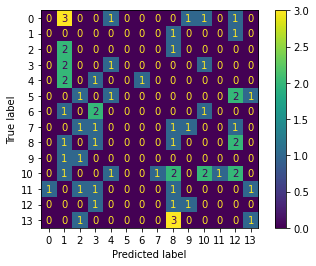

/tmp/ipykernel_3334350/2522279504.py:24: RuntimeWarning: divide by zero encountered in true_divide
  mean_conf_mat = mean_conf_mat.astype('float') / mean_conf_mat.sum(axis=1)
/tmp/ipykernel_3334350/2522279504.py:24: RuntimeWarning: invalid value encountered in true_divide
  mean_conf_mat = mean_conf_mat.astype('float') / mean_conf_mat.sum(axis=1)


Mean accuracy = 0.11538461538461539


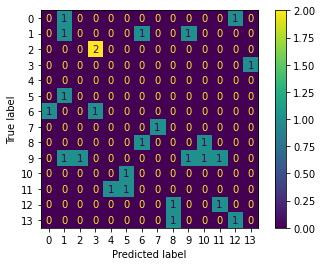

In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
confusion_matrix_test_loader = Data.DataLoader(test, batch_size = 64, shuffle = False)
with torch.no_grad():
    list_mean_accuracy = []
    for i, data in enumerate(confusion_matrix_test_loader, 0):
        # inputs, labels, bp = data
        # inputs, labels, bp = inputs.to(device), labels.type(torch.LongTensor).to(device), bp.to(device)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
        # outputs = rpsmnet(inputs, bp)
        outputs = rpsmnet(inputs)
        optimizer.step()          
        _, predicted = torch.max(outputs,1)
        # predicted = torch.max(outputs)
        labels = labels.cpu()
        predicted = predicted.cpu()
        labels = labels.numpy()
        predicted = predicted.numpy()
        # mean_conf_mat = confusion_matrix(labels, predicted)
        # mean_accuracy = accuracy_score(labels[labels != 99], predicted[predicted != 99])
        # mean_conf_mat = mean_conf_mat.astype('float') / mean_conf_mat.sum(axis=1)  # normalise
        mean_conf_mat = confusion_matrix(labels, predicted)
        mean_accuracy = accuracy_score(labels[labels != 99], predicted[predicted != 99])
        mean_conf_mat = mean_conf_mat.astype('float') / mean_conf_mat.sum(axis=1) 
        list_mean_accuracy.append(mean_accuracy)
        print("Mean accuracy = {0}".format(mean_accuracy))
        ConfusionMatrixDisplay.from_predictions(labels, predicted)
        # plt.savefig('/content/drive/MyDrive/MT_ML_Decoding/Aversive_state_reactivation/notebooks/templates/save_folder/fig-{}.png'.format(session_id), dpi=600)
        plt.show()

In [ ]:
torch.max(Testoutput,1)

torch.return_types.max(
values=tensor([7.1546, 7.4989, 7.2406, 7.4986, 7.0637, 7.2464, 6.8946, 7.2835, 6.9954,
        7.4655, 6.9324, 7.5937, 6.9544, 7.4460, 7.1179, 7.0397, 7.2257, 6.9913,
        7.2716, 7.4679, 7.6336, 7.2738, 6.9536, 7.2841, 7.0433, 7.3976, 7.6335,
        7.2979, 6.8528, 7.0941, 7.5488, 7.7630, 7.2037, 7.3379, 6.7545, 6.9814,
        7.1571, 7.2898, 7.2017, 7.1691, 7.8751, 7.2257], device='cuda:0',
       grad_fn=<MaxBackward0>),
indices=tensor([12, 11,  5,  2,  8,  1,  2, 13,  4,  6,  5, 10,  4,  7,  5,  6,  7,  8,
         1,  2,  0, 11,  4, 10,  5,  7,  9, 13, 13,  8, 11,  8,  7,  6, 12,  5,
        13,  1, 13, 12,  9,  5], device='cuda:0'))

In [ ]:
val_y

tensor([12, 11,  5,  2,  8,  1,  2, 13,  4,  6,  5, 10,  4,  7,  5,  6,  7,  8,
         1,  2,  0, 11,  4, 10,  5,  7,  9, 13, 13,  8, 11,  8,  7,  6, 12,  5,
        13,  1, 13, 12,  9,  5], device='cuda:0')

In [ ]:
!rm -rf /logs/ # clear logs
# if 'google.colab' in str(get_ipython()): # tensor board
%load_ext tensorboard  
# %tensorboard --logdir logs
%tensorboard --logdir=./models/test

## Test

In [ ]:
# class CNN(nn.Module):
#     def __init__(self):
#       # super(CNN, self)._init_()
#       super(CNN, self).__init__()
#       self.n_classes = 14
#       n_classes =14
#       self.conv1 = nn.Sequential(
#           nn.Conv2d(
#               in_channels=1,
#               out_channels=32,
#               kernel_size=3,
#               stride=1,
#               padding=1,
#           ),
#           nn.ReLU(),
#           nn.MaxPool2d(kernel_size=2,stride=2),
#       )
#       self.conv2 = nn.Sequential(
#           nn.Conv2d(32,64,3,1,1),
#           nn.ReLU(),
#           nn.MaxPool2d (2,2),
#       )
#       # self.fc = nn.Linear(64*7*7,128)
#       self.fc = nn.Linear(139264, 100)
#       self.out = nn.Linear(100,n_classes)
#       self.softmax = nn.Softmax()

#     def forward(self,x):
#       x=self.conv1(x)
#       x=self.conv2(x)
#       # x=x.view(x.size(0),-1)
#       x = torch.flatten(x, 1) # flatten all dimensioxns except batch
#       x=self.fc(x)
#       x=self.out(x)      
#       # output=self.out(x)
#       # return output, x
#       # x=self.softmax(x)
#       return x